In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


- https://zpl.fi/aligning-point-patterns-with-kabsch-umeyama-algorithm/
- https://pymolwiki.org/index.php/Kabsch#:~:text=The%20Kabsch%20algorithm%20uses%20linear,implementation%20of%20the%20Kabsch%20algorithm.
- https://stackoverflow.com/questions/60877274/optimal-rotation-in-3d-with-kabsch-algorithm
- https://towardsdatascience.com/the-definitive-procedure-for-aligning-two-sets-of-3d-points-with-the-kabsch-algorithm-a7ec2126c87e
- http://computerandchemistry.blogspot.com/2013/04/calculate-rmsd-from-two-xyz-files.html

- NOTE import own data? set import_matrices arg with default option if no data
- NOTE docstrings
- NOTE calculate RMSD? 
- NOTE generate visualisation of data? 

# Visualise two 3D shapes that need to be aligned
 - representative of e.g. two protein structures

In [15]:
# NOTE could modify so user can input own xyx values as function args

def generate_matrices():

    ax = plt.figure(figsize=(15,15)).add_subplot(projection='3d')

    # generate x, y, z co-ords and concat into matrix
    theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)

    A_z = np.linspace(-2, 2, 100)
    r = A_z**2 + 1
    A_x = r * np.sin(theta)
    A_y = r * np.cos(theta)

    B_z = np.linspace(-2, 2, 100)
    r = B_z**3 + 1 # switch to cubed instead of squared
    B_x = r * np.cos(theta) # switch sin and cos for x and y 
    B_y = r * np.sin(theta)

    ax.plot(A_x, A_y, A_z, label='A')
    ax.plot(B_x, B_y, B_z, label='B')
    ax.legend(loc='upper left', fontsize=20)
    ax.set_xlabel('X', fontsize=20)
    ax.set_ylabel('Y', fontsize=20)
    ax.set_zlabel('Z', fontsize=20)

    plt.show()

    # extract points into matrix
    A = np.matrix([A_x, A_y, A_z])
    B = np.matrix([B_x, B_y, B_z])

    return A, B

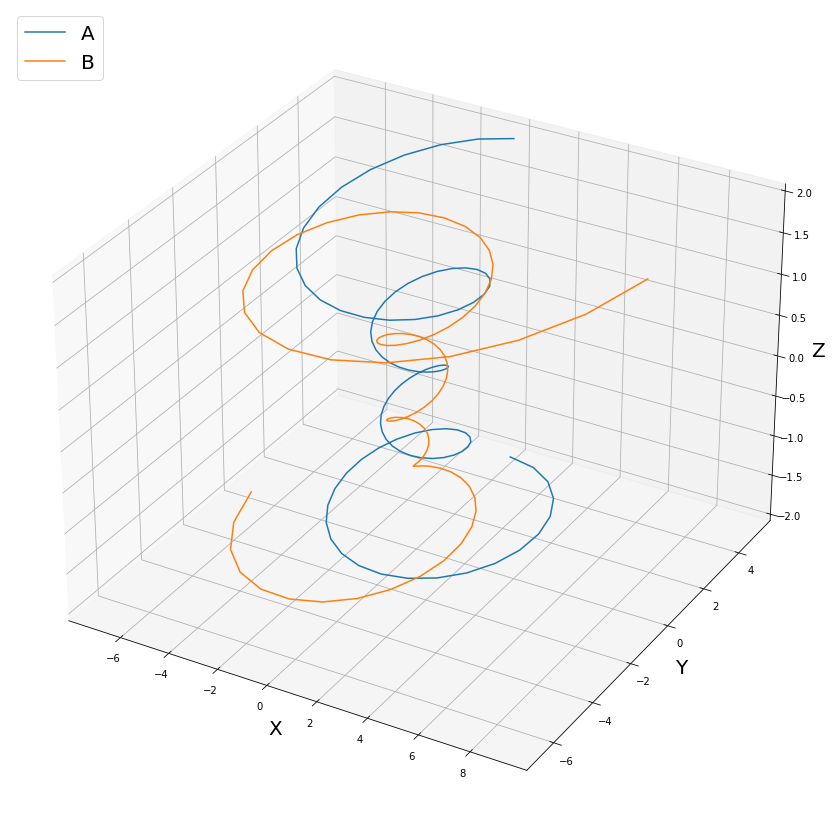

A:  (3, 100)
B:  (3, 100)


In [16]:
A, B = generate_matrices()

# returns 3x100 matrices
print('A: ', A.shape)
print('B: ', B.shape)

In [23]:
# 2 translate A and B so their centroids are on the origin (0,0,0) - do this by subtracting from each element the average of the whole column
def translate_to_origin(A, B):

    # find and store mean value for each column (x, y, z)
    Ax_mean, Ay_mean, Az_mean = np.mean(A, axis=1)
    Bx_mean, By_mean, Bz_mean = np.mean(B, axis=1)

    # A and B can be split into 3 cols of x,y,z co-ords
    Ax, Ay, Az = A
    Bx, By, Bz = B
    
    # set up lists of cols and means to iterate through
    columns = [Ax, Ay, Az, Bx, By, Bz] 
    means = [Ax_mean, Ay_mean, Az_mean, Bx_mean, By_mean, Bz_mean]

    # set up empty matrices to hold updated values
    translated_matrices = np.empty(shape=(6,100))
    translated_column = np.empty(shape=(1,100))

    # iterate through column values and substract column mean for each col in each matrix
    subtract = lambda column: column - mean
    subtract_func = np.vectorize(subtract)

    for column, mean in zip(columns, means):
        print('MEAN: ', mean)
        print('COLUMN: ', column[0,1])
        translated_column = subtract_func(column)
        print('TRANSLATED COL: ', translated_column[0,1])
        np.append(translated_matrices, translated_column)
    
    # separate results back into the two respective matrices A and B 
    A_translated = translated_matrices[0:3, 0:100]
    B_translated = translated_matrices[3:6, 0:100]


    return A_translated, B_translated, means

In [24]:
A_translated, B_translated, means = translate_to_origin(A=A, B=B)

MEAN:  [[1.02072489e-16]]
COLUMN:  1.2155603579133674
TRANSLATED COL:  1.2155603579133674
MEAN:  [[0.10042422]]
COLUMN:  4.684887516390055
TRANSLATED COL:  4.584463300006576
MEAN:  [[1.64313008e-16]]
COLUMN:  -1.9595959595959596
TRANSLATED COL:  -1.9595959595959598
MEAN:  [[0.01]]
COLUMN:  -6.3157495825306915
TRANSLATED COL:  -6.325749582530692
MEAN:  [[-0.6029187]]
COLUMN:  -1.6387105978902698
TRANSLATED COL:  -1.0357918933772594
MEAN:  [[1.64313008e-16]]
COLUMN:  -1.9595959595959596
TRANSLATED COL:  -1.9595959595959598


# Visualise data translated to origin

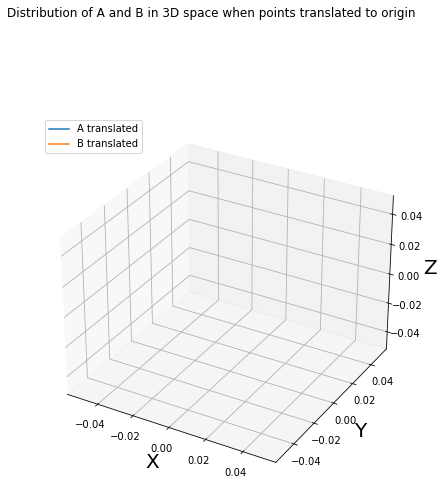

In [25]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(211, projection='3d')

Ax, Ay, Az = A_translated
Bx, By, Bz = B_translated

ax.plot(Ax, Ay, Az, label='A translated')
ax.plot(Bx, By, Bz, label='B translated')
ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)

plt.legend(loc='upper left')
plt.suptitle('Distribution of A and B in 3D space when points translated to origin')

plt.show()

# Step 3 find optimal rotation matrix that turns A as close as possible to B (minimise RMSD) & apply that rotation to A

In [26]:
def compute_covariance_matrix(A_translated, B_translated):
    
    # multiply Bt (transposed) by A (gives H)
    H = np.matmul(B_translated.T, A_translated)

    return H 

In [27]:
H = compute_covariance_matrix(A_translated=A_translated, B_translated=B_translated)

In [28]:
def compute_optimal_rotation_matrix(H):
    
    # find SVD of H 
    U, S, V = np.linalg.svd(H) # np.linalg.svd returns transpose of V
    Vt = V
    # keep matrices 1 and 3 from the decomposition (U and V) - will be Vt if python svd gives transposed V
    # rotation matrix R is Vt x Ut (transposed U) (transpose V if not given as transposed)
    R = np.matmul(Vt, U.T)

    return R

In [29]:
R = compute_optimal_rotation_matrix(H=H)

LinAlgError: SVD did not converge

In [30]:
def apply_rotation(A_translated, R):

    # to get rotated A, multiply A x R
    A_rotated = np.matmul(A_translated, R)

    return A_rotated

In [31]:
A_rotated = apply_rotation(A_translated=A_translated, R=R)

NameError: name 'R' is not defined

In [32]:
# 4 translate A back to where B originally was centered (add back averages to matrix columns)
def revert_translation(means, B_translated, A_rotated):

    # A and B can be split into 3 cols of x,y,z co-ords
    Ax, Ay, Az = A_rotated
    Bx, By, Bz = B_translated

    columns = [Ax, Ay, Az, Bx, By, Bz]

    # set up empty matrices to hold updated values
    reverted_matrices = np.empty(shape=(6,100))
    reverted_column = np.empty(shape=(1,100))

    # iterate through column values and substract column mean for each col in each matrix
    add = lambda column: column + mean
    add_func = np.vectorize(add)

    for column, mean in zip(columns, means):
        reverted_column = add_func(column)
        np.append(reverted_matrices, reverted_column)
    
    # separate results back into the two respective matrices A and B 
    A_reverted = reverted_matrices[0:3, 0:10]
    B_reverted = reverted_matrices[3:6, 0:10]

    return A_reverted, B_reverted

In [33]:
A_reverted, B_reverted = revert_translation(means=means, B_translated=B_translated, A_rotated=A_rotated)

NameError: name 'A_rotated' is not defined

NameError: name 'A_reverted' is not defined

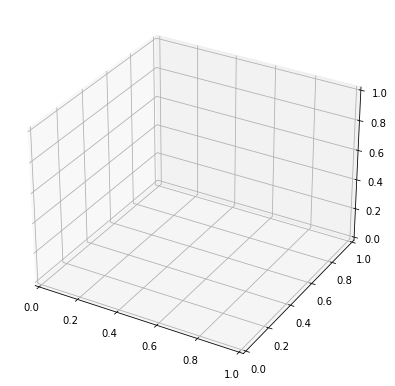

In [34]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(211, projection='3d')

Ax_rvt, Ay_rvt, Az_rvt = A_reverted
Bx_rvt, By_rvt, Bz_rvt = B_reverted

ax.plot(Ax_rvt, Ay_rvt, Az_rvt, label='A_reverted')
ax.plot(Bx_rvt, By_rvt, Bz_rvt, label='B_reverted')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.legend(loc='upper left')
plt.suptitle('Distribution of A_reverted and B_reverted in 3D space compared to A and B')

plt.show()

In [ ]:
def run_kabsch():

    A, B = import_matrices()
    print('A shape: ', A.shape)
    print('B shape: ', B.shape)
    A_translated, B_translated, means = translate_to_origin(A, B)
    H = compute_covariance_matrix(A_translated, B_translated)
    print('H shape: ', H.shape)
    R = compute_optimal_rotation_matrix(H)
    print('R shape: ', R.shape)
    A_rotated = apply_rotation(A_translated, R)
    print('A_rotated shape: ', A_rotated.shape)
    A_reverted, B_reverted = revert_translation(means=means, B_translated=B_translated, A_rotated=A_rotated)
    print('A_reverted shape: ', A_reverted.shape)
    print('B_reverted shape: ', B_reverted.shape)

    return A_reverted, B_reverted